In [57]:
from platform import python_version

In [58]:
python_version()

'3.7.5'

In [59]:
# Interactive plotting
# %matplotlib qt

import numpy as np
import mne
import os
from glob import glob
from itertools import compress

In [60]:
import hypyp

In [61]:
print(hypyp.__version__)

0.4.0b3


In [62]:
import mne

In [63]:
print(mne.__version__)

0.24.0


In [64]:
from hypyp.fnirs_tools import load_fnirs
from hypyp.fnirs_tools import make_fnirs_montage
from hypyp.fnirs_tools import fnirs_epoch
from hypyp.fnirs_tools import fnirs_montage_ui

In [65]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

durations = {
    'Block 1': 105,
    'Block 2': 120}

In [66]:
session_dirs = [d for d in glob(study_dir+"/*/V1/*/*") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

# subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [67]:
scans = []

for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
#     try:

    # get paths for each subject in dyad
    sub1 = os.path.join(dyad_dir, "Subject1")
    sub2 = os.path.join(dyad_dir, "Subject2")

    print(sub1)
    print(sub2)

    # make sure it has 'modern' .evt files
    evts = glob(sub1 + "/*.evt")
    if len(evts) != 2:
        print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
        continue

    # load each in via hypyp loader
    fnirs_participant_1 = load_fnirs(sub1, sub2, attr=None, preload=False, verbose=None)[0]
    fnirs_participant_2 = load_fnirs(sub1, sub2, attr=None, preload=False, verbose=None)[1]

    scans.append((fnirs_participant_1, fnirs_participant_2))

/data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7034/V1/2020-02-11_001/Subject1
/data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7034/V1/2020-02-11_001/Subject2
Loading /data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7034/V1/2020-02-11_001/Subject1
Loading /data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7034/V1/2020-02-11_001/Subject2
Loading /data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7034/V1/2020-02-11_001/Subject1
Loading /data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7034/V1/2020-02-11_001/Subject2
/data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7043/V1/2020-03-12_001/Subject1
/data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7043/V1/2020-03-12_001/Subject2
There should be 2 evt files. Skipping: Subject1
/data/perlman/moochie/analysis/Neurophotonics/JEN/NIRS_data_clean/7032/V1/2020-02-01_001/Subject1
/data/perlman/moochie/analysis/Neuroph

In [68]:
len(scans)

16

In [69]:
scans[0][0]

<RawNIRX | Subject1, 20 x 10123 (1295.6 s), ~31 kB, data not loaded>

In [70]:
# rename events and set durations for block 1 and 2
for dscan in scans:
    
    for scan in dscan:
        
        scan.annotations.rename({
            '1.0': 'Block 1',
            '2.0': 'Block 2'})
        
        scan.annotations.set_durations(durations, verbose=True)

In [71]:
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = []
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)
        
        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
        
        # resample to 4 Hz
        rs_od = tddr_od.resample(4, verbose=False)
        
        # highpass filter of 0.1 Hz
        bp_od = rs_od.filter(l_freq=0.01, h_freq=0.5, verbose=False)
        
        # haemoglobin conversion
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Reading 0 ... 10122  =      0.000 ...  1295.616 secs...
Bad channels in subject 7034-1 : ['S2_D1 760', 'S2_D1 850', 'S8_D4 760', 'S8_D4 850']
Reading 0 ... 10122  =      0.000 ...  1295.616 secs...
Bad channels in subject 7034-2 : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S7_D3 760', 'S7_D3 850', 'S8_D4 760', 'S8_D4 850']
Reading 0 ... 9673  =      0.000 ...  1238.144 secs...
Reading 0 ... 9673  =      0.000 ...  1238.144 secs...
Reading 0 ... 9230  =      0.000 ...  1181.440 secs...
Bad channels in subject 7022 : ['S1_D1 760', 'S1_D1 850']
Reading 0 ... 9230  =      0.000 ...  1181.440 secs...
Bad channels in subject 7022-2 : ['S1_D1 760', 'S1_D1 850']
Reading 0 ... 9474  =      0.000 ...  1212.672 secs...
Reading 0 ... 9474  =      0.000 ...  1212.672 secs...
Bad channels in subject 7035-2 : ['S1_D1 760', 'S1_D1 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Reading 0 ... 9689  =      0.000 ...  1240.192 secs.

In [72]:
total = 0
bad = 0

for dscan in pps:
    for scan in dscan:
        for ch in scan.info['ch_names']:
            total += 1
            if ch in scan.info['bads']:
                bad += 1
              
print(
    "% Channels kept after SCI < 0.5 threshold:",
    (total - bad) / total)

% Channels kept after SCI < 0.5 threshold: 0.9


In [73]:
epoched = []

for dscan in pps:
    
#     dscan.annotations.rename({
#     '1.0': 'Block 1',
#     '2.0': 'Block 2'})
        
#     dscan.annotations.set_durations(durations, verbose=True)
    
    fnirs_epos = fnirs_epoch(
        dscan[0],
        dscan[1],
        tmax = 105,
        baseline=None,
        preload=True,
        event_repeated='merge')
    
    epoched.append(fnirs_epos)

Used Annotations descriptions: ['Block 1', 'Block 2']
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 421 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Block 1', 'Block 2']
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 421 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Block 1', 'Block 2']
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 421 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Block 1', 'Block 2']
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 421 origin

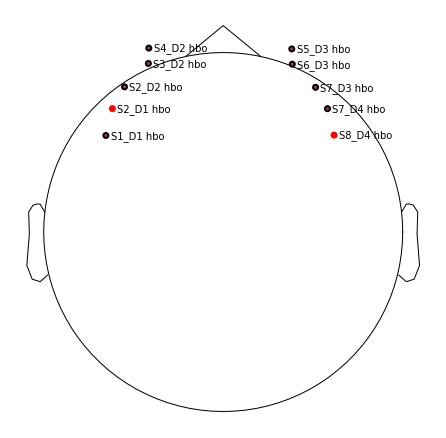

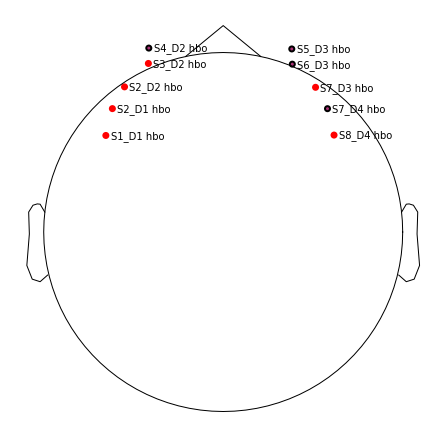

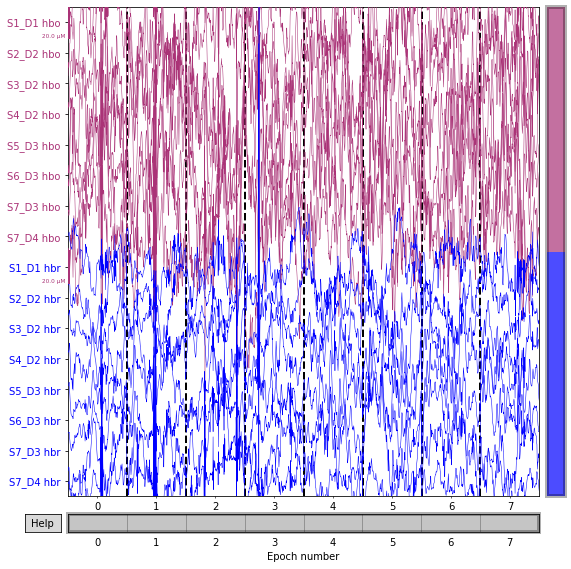

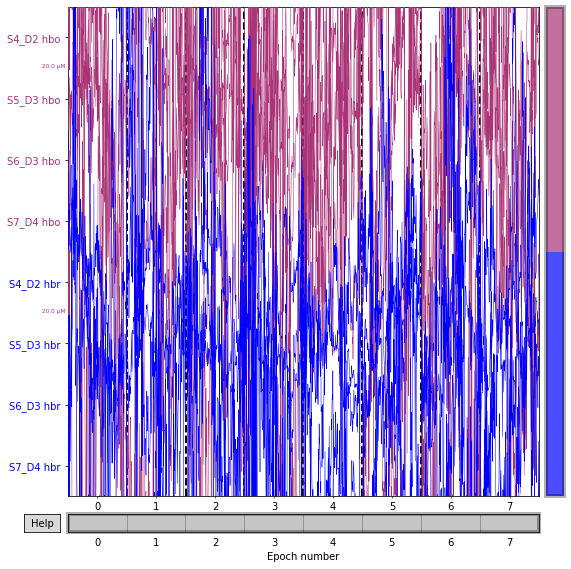

[[[0.15044966 0.14877789 0.19006174 0.20678857 0.14913891 0.13882932
   0.22547743 0.24701295 0.29968426 0.28731774 0.29632382 0.26876198
   0.23239328 0.29272847 0.22314925 0.17481745 0.28488608 0.25825122
   0.1511166  0.1336154 ]
  [0.16303648 0.12288863 0.19495426 0.17095485 0.19587399 0.15004586
   0.23842359 0.27362926 0.33327303 0.33354014 0.26966338 0.18193282
   0.22577086 0.34182243 0.14891774 0.13339412 0.31536079 0.31475043
   0.15259273 0.16811778]
  [0.13686496 0.12030194 0.19946149 0.15232742 0.1496269  0.14080133
   0.17669929 0.1750859  0.29421322 0.24045831 0.21564478 0.17265528
   0.22937529 0.19288946 0.20676742 0.1910886  0.24745593 0.24599671
   0.13776888 0.17470043]
  [0.11088897 0.09990716 0.17505398 0.15831995 0.16830047 0.14986981
   0.25590185 0.30067171 0.26954977 0.25786683 0.29589677 0.20039059
   0.24884999 0.22482315 0.17200902 0.13649042 0.31744315 0.25805728
   0.1367314  0.14804065]
  [0.16525357 0.17463645 0.18396589 0.14068138 0.21615999 0.20568556

/data/perlman/moochie/resources/server_access/HyPyPenv/lib/python3.7/site-packages/hypyp/analyses.py:696: RuntimeWarning: filter_length (661) is longer than the signal (421), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/data/perlman/moochie/resources/server_access/HyPyPenv/lib/python3.7/site-packages/hypyp/analyses.py:696: RuntimeWarning: filter_length (661) is longer than the signal (421), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)


In [74]:
# show info about each scan,
# and join into a complex_signal object for HyPyP

css = []

for epo in epoched[:1]:
    
    # split epo into named epoch objects
    epo1 = epo[0]
    epo2 = epo[1]
    
    # plot sensors (bads red)
    epo1.plot_sensors(show_names=True)
    epo2.plot_sensors(show_names=True)

    # plot epochs as well
    epo1.plot()
    epo2.plot()
    
    # splice data
    data_inter = np.array([epo1, epo2])

    # make complex signal from task-related frequency bands
    complex_signal = hypyp.analyses.compute_freq_bands(
        data_inter,
        epo1.info['sfreq'],
        {'task': [0.02, 0.1]})
    
    result_inter = []
    result_intra = []
    
    # append to list of complex signals
    css.append(complex_signal)
    
    # get synchrony results for epochs.
    # computing frequency- and time-frequency-domain connectivity
    result = hypyp.analyses.compute_sync(complex_signal, mode='coh')
    
    # slicing results to get the inter-brain part of the matrix
    n_ch = len(epo1.info['ch_names'])
    task = result[:, 0:n_ch, n_ch:2*n_ch]
    values = task

    print(values)
        
# computing Cohen's D for further analyses for example?
#     C = (values - np.mean(values[:])) / np.std(values[:])
#     print("Cohen's:", C)
    
#     # slicing results to get the intra-brain part of the matrix
#     for i in [0, 1]:
#         task = result[:, (i * n_ch):((i + 1) * n_ch), (i * n_ch): ((i + 1) * n_ch)]
#         values_intra = task
#         values_intra -= np.diag(np.diag(values_intra))
#         # computig Cohen's D for further analyses for example
#         C_intra = (values_intra - np.mean(values_intra[:])) / np.std(values_intra[:]) 
        
#         result_intra.append(C_intra)

In [78]:
complex_signal.shape

(2, 8, 20, 1, 421)

In [75]:
for complex_signal in css:
    
    result = hypyp.analyses.compute_sync(
        complex_signal,
        mode='wavelet_coh')
    print(result)

UnboundLocalError: local variable 'con' referenced before assignment

In [76]:
len(scans)

16

In [ ]:
# #Sources ' labels: S#
# source_labels = ['S1','S2','S3','S4]
# #Sources ' labels: D#
# detector_labels = ['D1','D2','D3','D4','D5','D6','D7','D8']
# #directory of the probeInfo.mat file
# prob_mat_file = '../data/FNIRS/MCARE_01_probeInfo.mat'
# #3D Coordination of the tip of the nose: [x, y, z] in mm
# Nz_coord = [12.62, 17.33, 16.74]
# #3D Coordination of the right preauricular: [x, y, z] in mm
# RPA = [21.0121020904262, 15.9632489747085, 17.2796094659563]
# #3D Coordination of the left preauricular: [x, y, z] in mm
# LPA = [4.55522116441745, 14.6744377188919, 18.3544292678269]
# #Head size in mm
# head_size = 0.16

# location = make_fnirs_montage(source_labels, detector_labels, prob_mat_file,
#                               Nz_coord, RPA, LPA, head_size)